In [2]:
import os

# Change the current working directory to your desired path
os.chdir('/Users/Yash/Downloads/aptos2019-blindness-detection')

# Verify the change
print('Current Working Directory is', os.getcwd())

Current Working Directory is /Users/Yash/Downloads/aptos2019-blindness-detection


In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ', os.getcwd())

# Visualization Libraries
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libraries
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from multiprocessing.pool import ThreadPool
from sklearn.metrics import cohen_kappa_score, accuracy_score

CWD is  /Users/Yash/Downloads/aptos2019-blindness-detection


In [4]:
#reads data from csv files
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [5]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  ./train_images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  ./train_images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  ./train_images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  ./train_images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  ./train_images/005b95c28852.png  005b95c28852.png
5  0083ee8054ee         4  ./train_images/0083ee8054ee.png  0083ee8054ee.png

In [6]:
IMG_SIZE = 200

In [7]:
'''This Function converts a color image to gray scale image'''

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img
  
    
'''
This Function shows the visual Image photo 
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

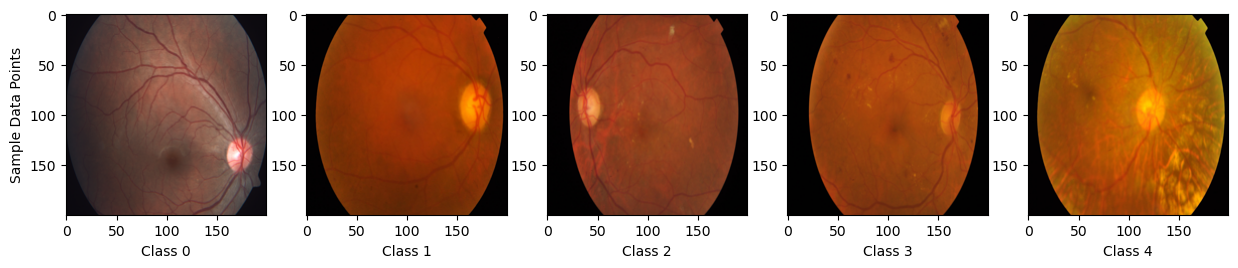

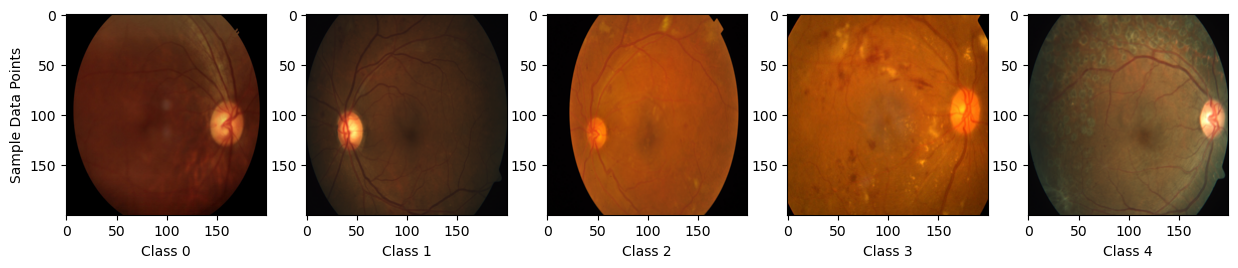

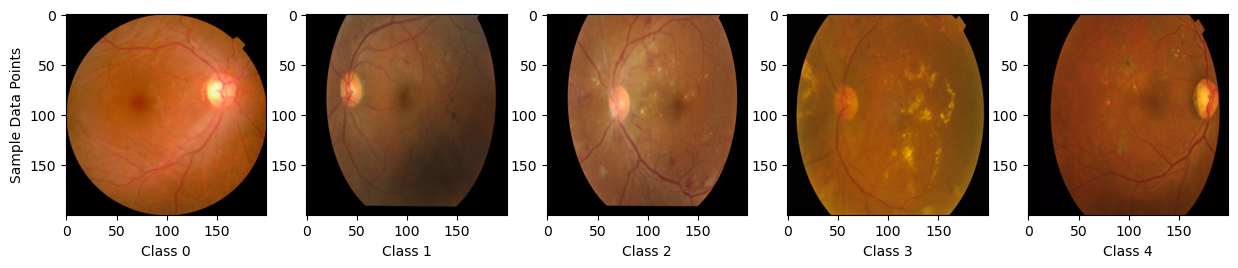

In [8]:
visualize_imgs(df_train,3,color_scale = None)

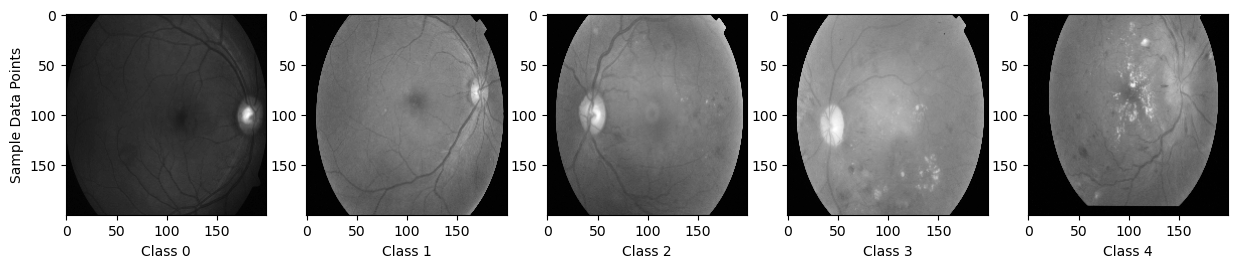

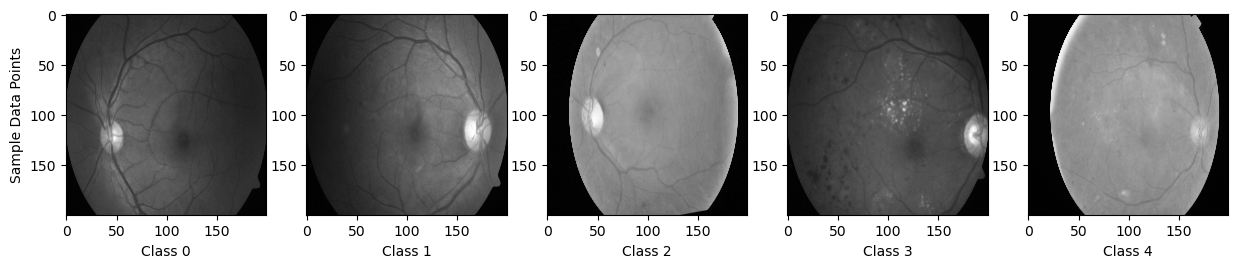

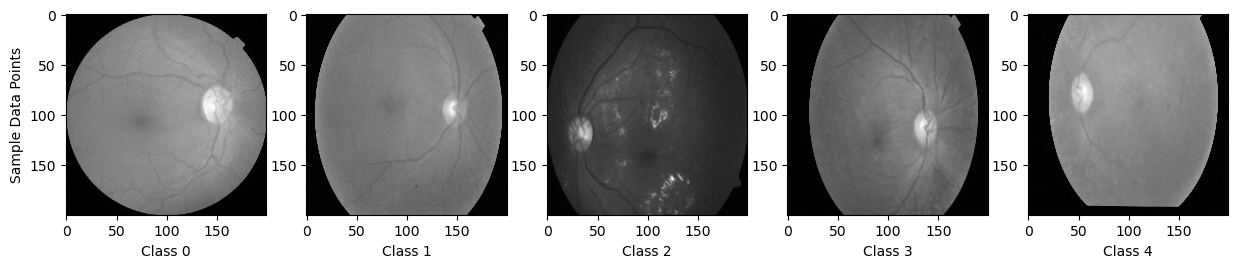

In [9]:
visualize_imgs(df_train,3,color_scale = 'gray')

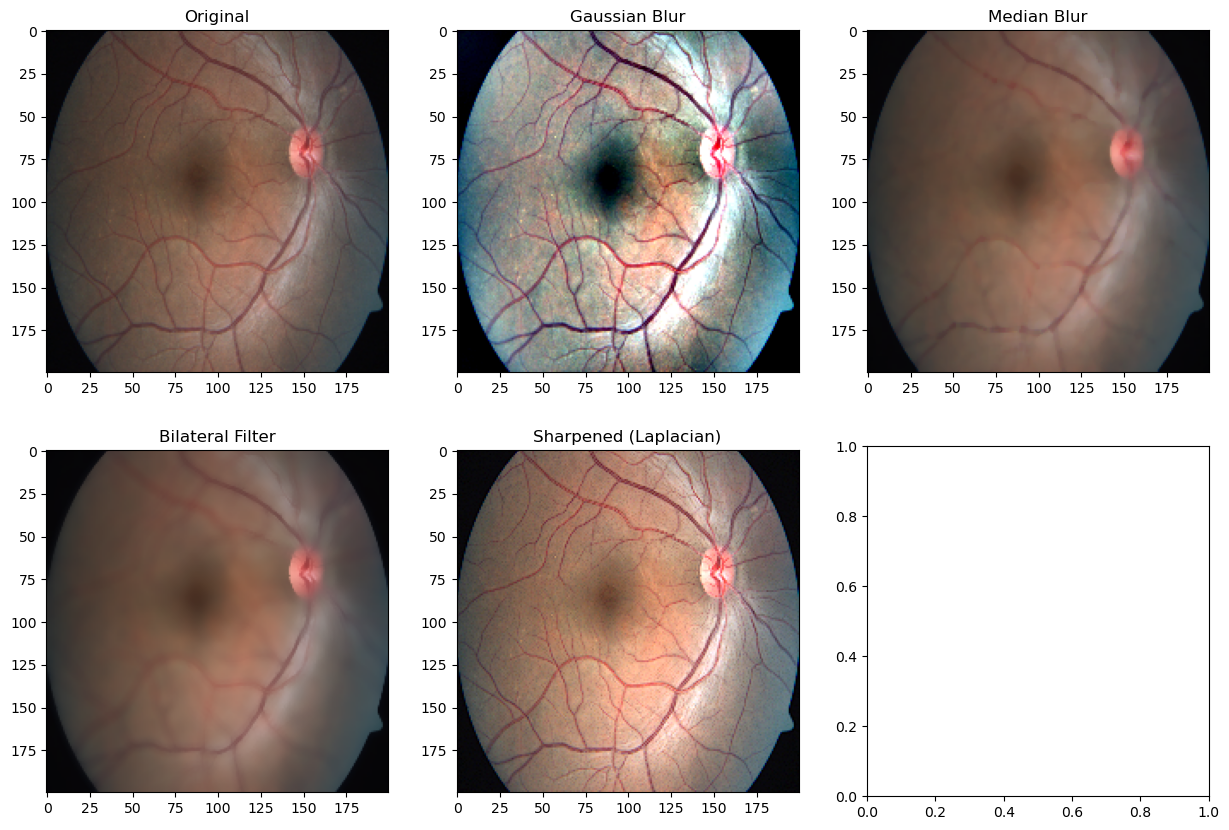

In [10]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

img_median = cv2.medianBlur(img, 5)  # Kernel size 5

# Bilateral Filter
img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)  # Diameter 9, sigmaColor 75, sigmaSpace 75

# Sharpening (Using Laplacian filter)
img_laplacian = cv2.Laplacian(img, cv2.CV_64F)
img_laplacian = np.clip(img_laplacian, 0, 255).astype(np.uint8)  # Convert to uint8

img_sharpened = cv2.addWeighted(img, 1.5, img_laplacian, -0.5, 0) 
img_sharpened = np.clip(img_sharpened, 0, 255).astype(np.uint8)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(img)
axes[0, 0].set_title('Original')
axes[0, 1].imshow(img_t)
axes[0, 1].set_title('Gaussian Blur')
axes[0, 2].imshow(img_median)
axes[0, 2].set_title('Median Blur')
axes[1, 0].imshow(img_bilateral)
axes[1, 0].set_title('Bilateral Filter')
axes[1, 1].imshow(img_sharpened)
axes[1, 1].set_title('Sharpened (Laplacian)')
plt.show()

In [11]:

'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

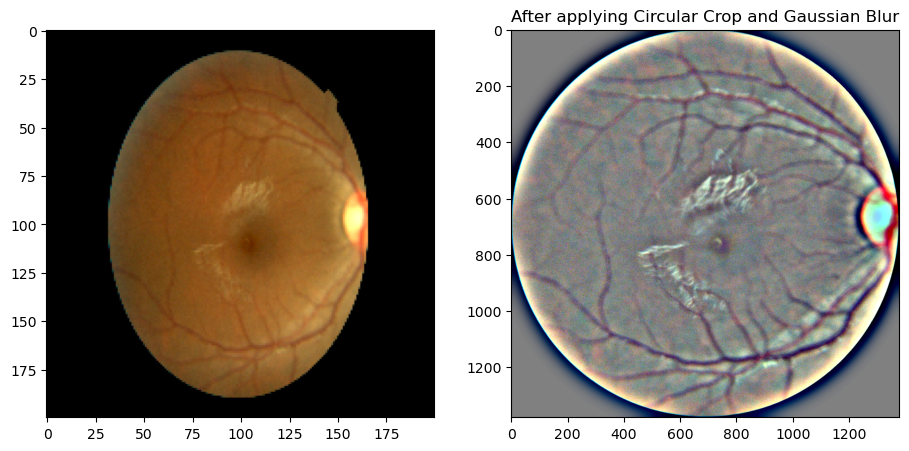

In [12]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

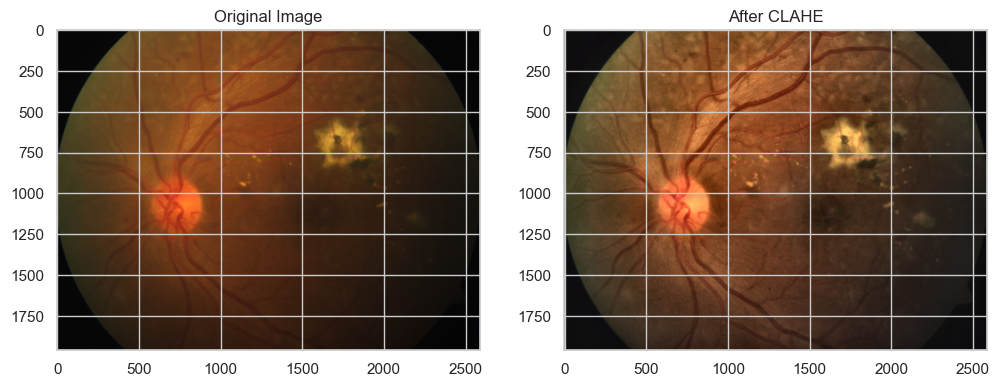

In [80]:
#CLAHE

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def apply_clahe(directory):
    # Get a list of all image files in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Pick a random image file
    random_image_path = random.choice(image_files)
    
    # Read the image
    img = cv2.imread(random_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))

    # Convert back to RGB
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Display the original and CLAHE image
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(img), plt.title('Original Image')
    plt.subplot(122), plt.imshow(final), plt.title('After CLAHE')
    plt.show()

# Usage: specify your directory path
apply_clahe('/Users/Yash/Downloads/aptos2019-blindness-detection/train_images')

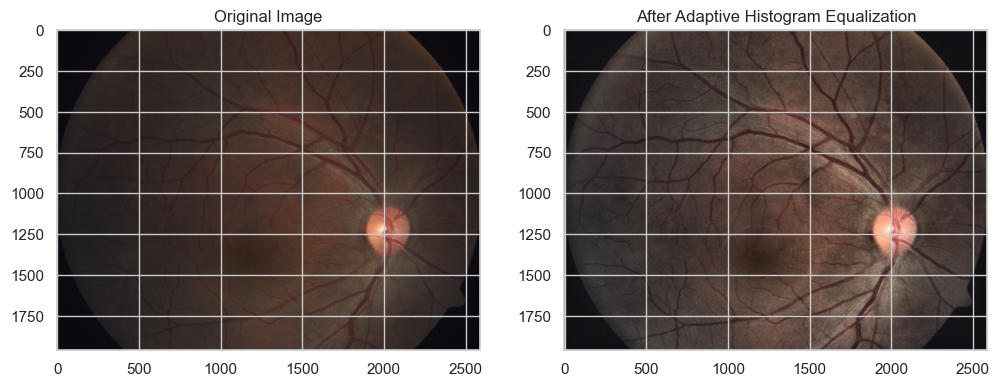

In [88]:
#Adaptive Histogram 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def apply_adaptive_histogram_equalization(directory):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_image_path = random.choice(image_files)

    img = cv2.imread(random_image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to LAB color space to apply CLAHE on the luminance channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    merged_lab = cv2.merge((l, a, b))
    final_img = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(img), plt.title('Original Image')
    plt.subplot(122), plt.imshow(final_img), plt.title('After Adaptive Histogram Equalization')
    plt.show()

# Usage
apply_adaptive_histogram_equalization('/Users/Yash/Downloads/aptos2019-blindness-detection/train_images')

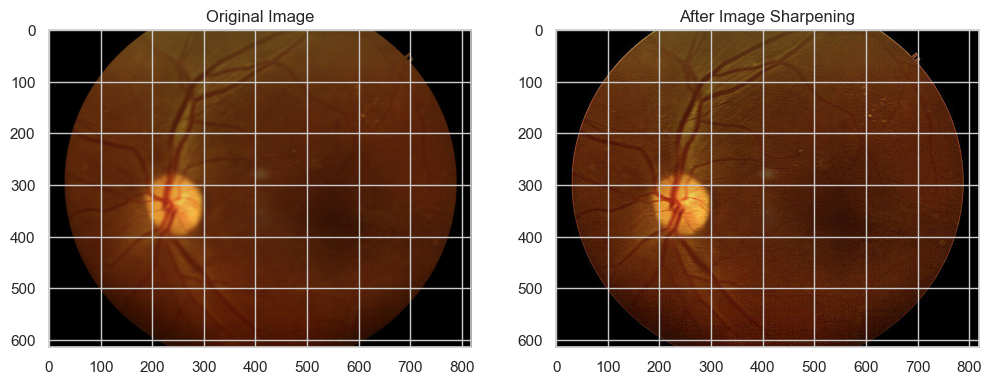

In [96]:
#Image Sharpening
def apply_image_sharpening(directory):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_image_path = random.choice(image_files)

    img = cv2.imread(random_image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Sharpening filter
    sharpen_filter = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
    sharpened_img = cv2.filter2D(img, -1, sharpen_filter)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(img), plt.title('Original Image')
    plt.subplot(122), plt.imshow(sharpened_img), plt.title('After Image Sharpening')
    plt.show()

# Usage
apply_image_sharpening('/Users/Yash/Downloads/aptos2019-blindness-detection/train_images')


In [13]:
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

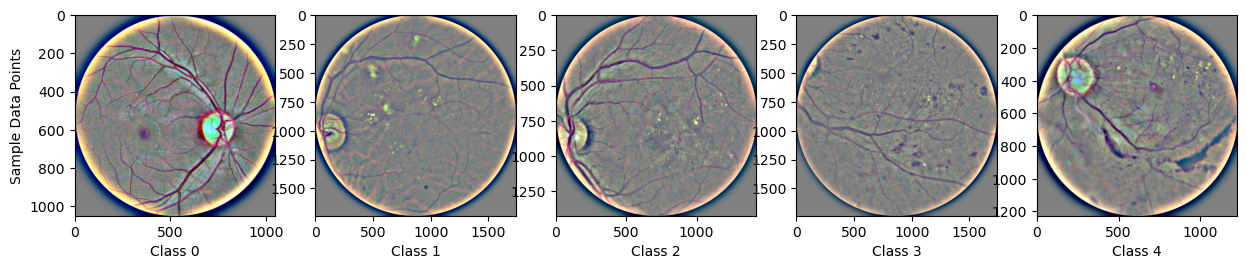

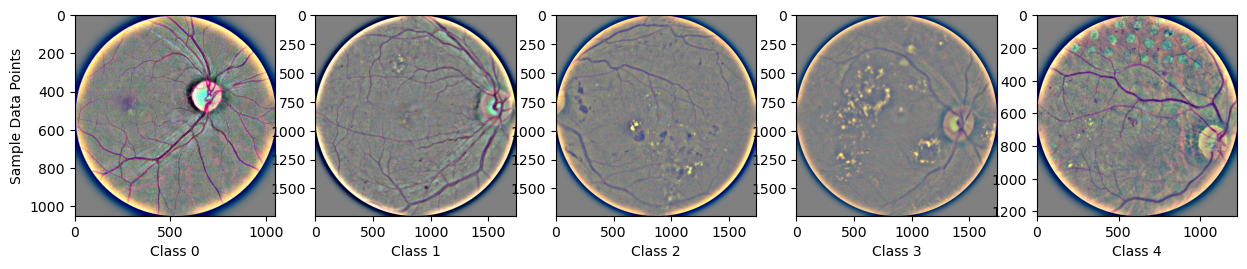

In [14]:
visualize_img_process(df_train,2,sigmaX = 30)

In [15]:
'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

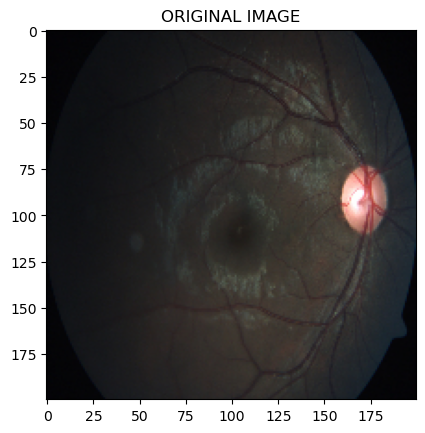

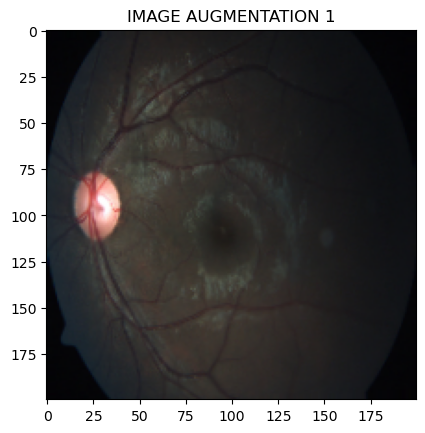

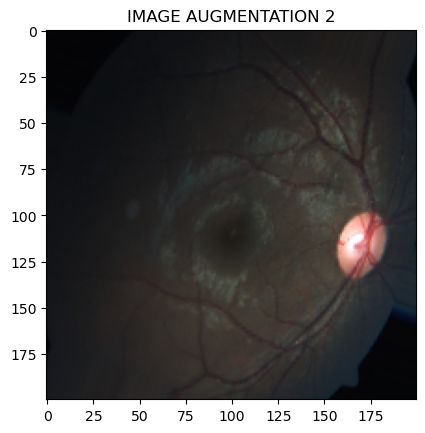

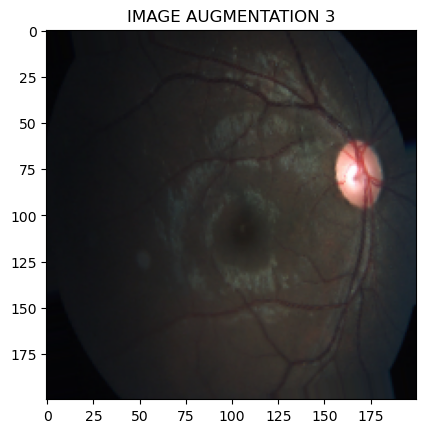

In [16]:
generate_augmentations(3)

In [17]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

In [18]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  ./train_images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  ./train_images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  ./train_images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  ./train_images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  ./train_images/005b95c28852.png  005b95c28852.png
5  0083ee8054ee         4  ./train_images/0083ee8054ee.png  0083ee8054ee.png

In [19]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2, random_state=42)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [20]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

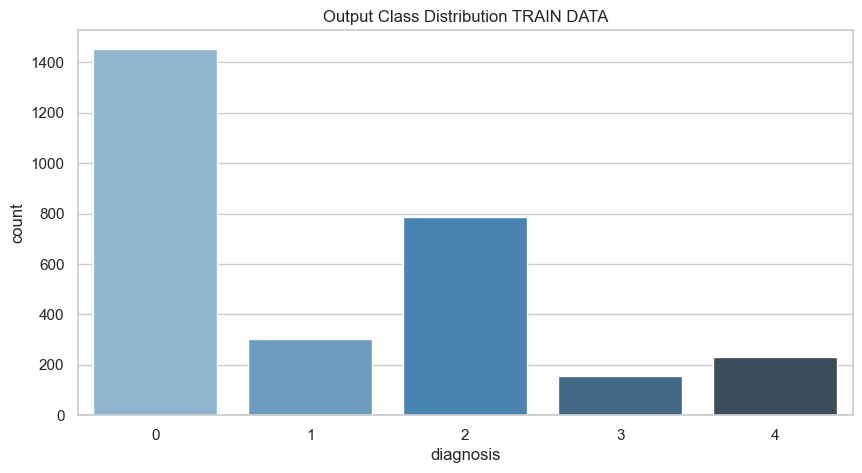

In [21]:
plot_classes(df_train_train,"TRAIN DATA")

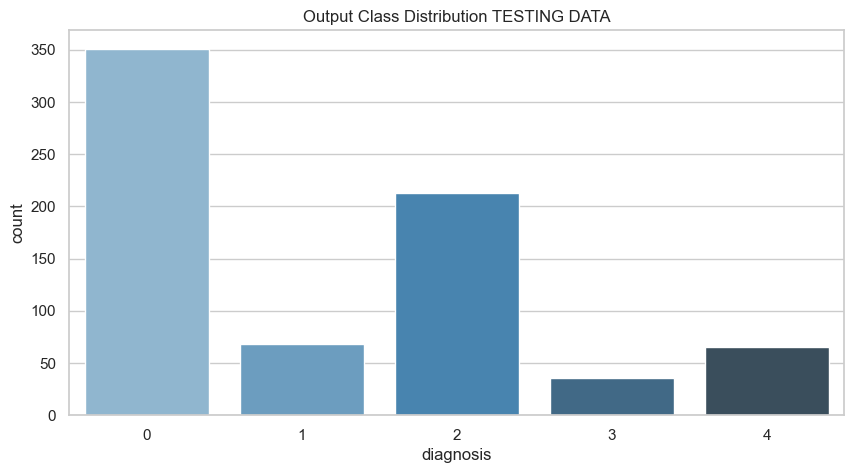

In [22]:
plot_classes(df_train_test,'TESTING DATA')

In [23]:
import os
print("Files in Current Directory:", os.listdir('/Users/Yash/Downloads/aptos 2015-2019 combined'))



Files in Current Directory: ['test_images', 'df_train_train.pkl', '.DS_Store', 'Diabetic Retinopathy Using Deep Learning.pdf', 'labels', 'df_train_test.pkl', 'train_images', 'df_train_valid.pkl']


In [24]:
# Use raw string for the path or ensure correct escaping
with open(r'/Users/Yash/Downloads/aptos2019-blindness-detection/df_train_train.pkl', 'wb') as file:
    pickle.dump(df_train_train, file)

with open(r'/Users/Yash/Downloads/aptos2019-blindness-detection/df_train_test.pkl', 'wb') as file:
    pickle.dump(df_train_test, file)

In [25]:
print(df_train_train.shape,df_train_test.shape)
print(len(os.listdir('./train_images_resized_preprocessed')),len(os.listdir('./test_images_resized_preprocessed')))

(2929, 4) (733, 4)
2929 2661


In [26]:
IMG_SIZE  = 512
'''Function loads an image from Folder , Resizes and saves in another directory '''

def image_resize_save(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','valid_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
#image_resize_save(df_train.id_code.iloc[201])
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results


In [27]:
multiprocess_image_downloader(6, list(df_train_test.id_code.values))

MESSAGE: Running 6 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [28]:
import cv2
import numpy as np
import os
from multiprocessing.pool import ThreadPool

def crop_image_from_gray(img, tol=7):
    if img is None:
        return None
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def circle_crop(img, sigmaX=30):
    if img is None:
        return None
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    if img is None:
        return None
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

def preprocess_image(file):
    IMG_SIZE = 256  # Define your IMG_SIZE if not defined
    input_filepath = os.path.join('./test_images_resized', f'{file}.png')
    output_filepath = os.path.join('./test_images_resized_preprocessed', f'{file}.png')

    img = cv2.imread(input_filepath)
    if img is None:
        print(f"Failed to load image {file}")
        return
    img = circle_crop(img)
    if img is None:
        print(f"Failed to process image {file}")
        return
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))

def multiprocess_image_processor(process, imgs):
    print(f'MESSAGE: Running {process} processes')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

# Example call, assuming df_train_test has id_code attribute containing image filenames
#multiprocess_image_processor(6, list(df_train_test['id_code'].values))

In [29]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [30]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [60]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [32]:
'''#CUSTOM
# Setting up the constants
IMG_HEIGHT = 320
IMG_WIDTH = 320
CHANNELS = 3
LEARNING_RATE = 1e-4

# Building the CNN model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output of the last pooling layer to feed into the dense layer
model.add(Flatten())
flat_output_size = model.output_shape[1]  # Dynamically get the output size of the Flatten layer

# Fully Connected Layers
model.add(Dense(flat_output_size, activation='relu'))  # Automatically adapt to the output size of Flatten layer
model.add(Dropout(0.5))  # Help prevent overfitting
model.add(Dense(5, activation='softmax'))  # Output layer for 5 classes

# Compiling the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Checking the model structure
model.summary()

# Evaluating the model on train images
train_generator.reset()
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
train_loss, train_acc = model.evaluate(train_generator, steps=STEP_SIZE_TRAIN)
print(f"Train Accuracy: {train_acc}")'''



'#CUSTOM\n# Setting up the constants\nIMG_HEIGHT = 320\nIMG_WIDTH = 320\nCHANNELS = 3\nLEARNING_RATE = 1e-4\n\n# Building the CNN model\nmodel = Sequential()\n\n# Convolutional Block 1\nmodel.add(Conv2D(64, (3, 3), activation=\'relu\', padding=\'same\', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\n# Convolutional Block 2\nmodel.add(Conv2D(128, (3, 3), activation=\'relu\', padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\n# Convolutional Block 3\nmodel.add(Conv2D(256, (3, 3), activation=\'relu\', padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\n# Flattening the output of the last pooling layer to feed into the dense layer\nmodel.add(Flatten())\nflat_output_size = model.output_shape[1]  # Dynamically get the output size of the Flatten layer\n\n# Fully Connected Layers\nmodel.add(Dense(flat_output_size, activatio

In [64]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import cohen_kappa_score

# Constants
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 20

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Assuming df_train_train and df_train_test are defined elsewhere and have appropriate 'file_name' and 'diagnosis' columns
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_train,
    directory="./train_images_resized_preprocessed/",
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_train,
    directory="./train_images_resized_preprocessed/",
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),

    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_train_test,
    directory="./test_images_resized_preprocessed/",
    x_col="file_name",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode=None,
    
)

# Model definition
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to monitor the validation loss and restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure the correct steps per epoch based on actual batch availability
steps_per_epoch = (train_generator.n // train_generator.batch_size) + (train_generator.n % train_generator.batch_size > 0)
validation_steps = (valid_generator.n // valid_generator.batch_size) + (valid_generator.n % valid_generator.batch_size > 0)

# Reset generators
train_generator.reset()
valid_generator.reset()


# Model Training
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1  # Ensure this line is correctly comma-separated
)

# Evaluate model on the training set for accuracy
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // train_generator.batch_size)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

'''# Evaluate model on test set for accuracy and calculate Cohen's Kappa Score
y_pred = model.predict(test_generator, steps=test_generator.n)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes  # Assuming the classes are properly set

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Test Accuracy: {accuracy}")

# Calculate Cohen's Kappa Score
kappa = cohen_kappa_score(y_true_classes, y_pred_classes, weights='quadratic')
print(f"Cohen's Kappa Score: {kappa}")'''

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.
Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 491s 7s/step - accuracy: 0.5524 - loss: 24.6930 - val_accuracy: 0.1024 - val_loss: 73.3501
Epoch 2/20
 1/73 ━━━━━━━━━━━━━━━━━━━━ 9:42 8s/step - accuracy: 0.6875 - loss: 1.0597

2024-10-22 15:19:15.874986: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6875 - loss: 1.0597 - val_accuracy: 0.1111 - val_loss: 58.7937
Epoch 3/20


2024-10-22 15:19:16.197352: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


73/73 ━━━━━━━━━━━━━━━━━━━━ 558s 8s/step - accuracy: 0.6454 - loss: 1.4958 - val_accuracy: 0.1042 - val_loss: 75.4853
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5625 - loss: 1.6491 - val_accuracy: 0.0000e+00 - val_loss: 58.6681
Epoch 5/20


2024-10-22 15:28:41.515344: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


73/73 ━━━━━━━━━━━━━━━━━━━━ 492s 7s/step - accuracy: 0.6820 - loss: 0.9488 - val_accuracy: 0.1927 - val_loss: 55.0562
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6562 - loss: 0.9525 - val_accuracy: 0.1111 - val_loss: 75.8361
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 482s 7s/step - accuracy: 0.6984 - loss: 0.8533 - val_accuracy: 0.2448 - val_loss: 32.9771
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6562 - loss: 0.8088 - val_accuracy: 0.0000e+00 - val_loss: 36.5762
Epoch 9/20


2024-10-22 15:45:15.356199: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


73/73 ━━━━━━━━━━━━━━━━━━━━ 569s 8s/step - accuracy: 0.6951 - loss: 0.8583 - val_accuracy: 0.2795 - val_loss: 11.2954
Epoch 10/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7500 - loss: 0.9012 - val_accuracy: 0.3333 - val_loss: 7.8996
Epoch 11/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 570s 8s/step - accuracy: 0.6913 - loss: 0.8283 - val_accuracy: 0.5191 - val_loss: 1.7060
Epoch 12/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7812 - loss: 0.5299 - val_accuracy: 0.3333 - val_loss: 1.2360
Epoch 13/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 570s 8s/step - accuracy: 0.6970 - loss: 0.8115 - val_accuracy: 0.6493 - val_loss: 1.1139
Epoch 14/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7500 - loss: 0.6583 - val_accuracy: 0.7778 - val_loss: 0.9543
Epoch 15/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 540s 7s/step - accuracy: 0.6955 - loss: 0.8057 - val_accuracy: 0.6719 - val_loss: 0.9417
Epoch 16/20
 1/73 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - accuracy: 0.6875 - loss: 0.6956

2024-10-22 16:23:18.140083: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6875 - loss: 0.6956 - val_accuracy: 0.5556 - val_loss: 0.8486
Epoch 17/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 556s 8s/step - accuracy: 0.7076 - loss: 0.8407 - val_accuracy: 0.6962 - val_loss: 0.8410
Epoch 18/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7188 - loss: 0.8038 - val_accuracy: 0.7778 - val_loss: 0.3912
Epoch 19/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 545s 7s/step - accuracy: 0.7246 - loss: 0.7933 - val_accuracy: 0.7153 - val_loss: 0.7825
Epoch 20/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5938 - loss: 0.8600 - val_accuracy: 0.5556 - val_loss: 0.9986
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 883ms/step - accuracy: 0.7361 - loss: 0.6967
Training Loss: 0.6808957457542419, Training Accuracy: 0.7534246444702148


'# Evaluate model on test set for accuracy and calculate Cohen\'s Kappa Score\ny_pred = model.predict(test_generator, steps=test_generator.n)\ny_pred_classes = np.argmax(y_pred, axis=1)\ny_true_classes = test_generator.classes  # Assuming the classes are properly set\n\n# Calculate accuracy\naccuracy = np.mean(y_pred_classes == y_true_classes)\nprint(f"Test Accuracy: {accuracy}")\n\n# Calculate Cohen\'s Kappa Score\nkappa = cohen_kappa_score(y_true_classes, y_pred_classes, weights=\'quadratic\')\nprint(f"Cohen\'s Kappa Score: {kappa}")'

In [65]:
# Reset test generator
test_generator.reset()

# Calculate the number of steps for the test set
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

# Use predict() instead of predict_generator()
test_preds = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# Convert predictions to class indices
test_labels = [np.argmax(pred) for pred in test_preds]



733/733 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step


In [43]:
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // train_generator.batch_size)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 884ms/step - accuracy: 0.7405 - loss: 0.6712
Training Loss: 0.66977459192276, Training Accuracy: 0.7414383292198181


In [68]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))


Test Cohen Kappa score: 0.453
Test Accuracy score : 0.501
